As a data scientist in a retail company, your task is to predict customer lifetime value based on transaction data, including purchase frequency, average transaction amount, and customer retention rate. Develop a regression model that accurately estimates CLV, and interpret which factors most significantly influence customer value. Test different regression approaches, including linear, ridge, and lasso regression, and report on model performance.

# PreProcessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [ ]:
customer_df = pd.read_csv('customer_segmentation.csv', encoding = 'latin-1')
print(customer_df.info)
print(customer_df.describe())
print(customer_df.dtypes)
print(customer_df.head(10))


<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

          InvoiceDate  UnitPrice  CustomerI

In [ ]:
#Check for duplication
customer_df.duplicated().sum() #5268 missing values
customer_df.drop_duplicates(inplace=True)
print(customer_df.duplicated().sum())
#Check for missing value
customer_df.isnull().sum()

#Drop rows for missing value in description and customerID (1454,134037 respectively)
customer_df.dropna(subset =['Description'],inplace = True)
customer_df.isnull().sum()
customer_df.dropna(subset = ['CustomerID'],inplace = True)
customer_df.isnull().sum()

0


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
# Label Encode InvoiceNo and StockCode into int
le = LabelEncoder()
customer_df['InvoiceNo'] = le.fit_transform(customer_df['InvoiceNo'])
customer_df['StockCode'] = le.fit_transform(customer_df['StockCode'])

# Convert InvoiceDate to datetime (ensure this step works correctly)
customer_df['InvoiceDate'] = pd.to_datetime(customer_df['InvoiceDate'], format='%m/%d/%y %H:%M', errors='coerce')

# Check if InvoiceDate has invalid entries, print and review
if customer_df['InvoiceDate'].isnull().sum() > 0:
    print("Error: InvoiceDate contains invalid values!")
    print(customer_df[customer_df['InvoiceDate'].isnull()])
    exit()  #Stop the execution if errors exist in the InvoiceDate

# Add InvoiceYear, InvoiceMonth, InvoiceDay, and InvoiceHour
customer_df['InvoiceYear'] = customer_df['InvoiceDate'].dt.year
customer_df['InvoiceMonth'] = customer_df['InvoiceDate'].dt.month
customer_df['InvoiceDay'] = customer_df['InvoiceDate'].dt.day
customer_df['InvoiceHour'] = customer_df['InvoiceDate'].dt.hour

# Calculate FirstPurchase, LastPurchase, and CustomerRetention
customer_df['FirstPurchase'] = customer_df.groupby('CustomerID')['InvoiceDate'].transform('min')
customer_df['LastPurchase'] = customer_df.groupby('CustomerID')['InvoiceDate'].transform('max')
customer_df['CustomerRetention'] = (customer_df['LastPurchase'] - customer_df['FirstPurchase']).dt.days

# Drop InvoiceDate column (only after retention calculation)
customer_df.drop(columns=['InvoiceDate'], inplace=True)

# Check the updated dataframe
print(customer_df.head(10))


   InvoiceNo  StockCode                          Description  Quantity  \
0          0       3249   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          0       2649                  WHITE METAL LANTERN         6   
2          0       2855       CREAM CUPID HEARTS COAT HANGER         8   
3          0       2803  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4          0       2802       RED WOOLLY HOTTIE WHITE HEART.         6   
5          0       1605         SET 7 BABUSHKA NESTING BOXES         2   
6          0        755    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7          1       1490               HAND WARMER UNION JACK         6   
8          1       1489            HAND WARMER RED POLKA DOT         6   
9          2       3069        ASSORTED COLOUR BIRD ORNAMENT        32   

   UnitPrice  CustomerID         Country  InvoiceYear  InvoiceMonth  \
0       2.55     17850.0  United Kingdom         2010            12   
1       3.39     17850.0  United Kingdom   

In [ ]:
# Calculate the total spend per transaction
customer_df['TotalAmount'] = customer_df['Quantity'] * customer_df['UnitPrice']

# Calculate average transaction amount grouped by CustomerID
avg_transaction = customer_df.groupby('CustomerID')['TotalAmount'].mean().reset_index()
avg_transaction.rename(columns={'TotalAmount': 'AvgTransactionAmount_ByCusID'}, inplace=True)

# Merge the average transaction amount back into the main dataframe
customer_df = customer_df.merge(avg_transaction, on='CustomerID', how='left')

# Add AverageTransactionAmount only if it's required separately
# (e.g., for referencing individual transaction amounts)
if 'AverageTransactionAmount' not in customer_df.columns:
    customer_df['AverageTransactionAmount'] = customer_df['TotalAmount']  # Keep for compatibility

# Ensure the dataset is ready for downstream use
print(customer_df.head())


   InvoiceNo  StockCode                          Description  Quantity  \
0          0       3249   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          0       2649                  WHITE METAL LANTERN         6   
2          0       2855       CREAM CUPID HEARTS COAT HANGER         8   
3          0       2803  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4          0       2802       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country  InvoiceYear  InvoiceMonth  \
0       2.55     17850.0  United Kingdom         2010            12   
1       3.39     17850.0  United Kingdom         2010            12   
2       2.75     17850.0  United Kingdom         2010            12   
3       3.39     17850.0  United Kingdom         2010            12   
4       3.39     17850.0  United Kingdom         2010            12   

   InvoiceDay  InvoiceHour       FirstPurchase        LastPurchase  \
0           1            8 2010-12-01 08:26:00 2011-02-10 

In [ ]:
#Create purchase frequency
purchase_frequency = customer_df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
purchase_frequency.rename(columns={'InvoiceNo':'PurchaseFrequency'},inplace = True)
print(purchase_frequency.head())
#Merge it back to the main dataset
customer_df = customer_df.merge(purchase_frequency, on='CustomerID', how='left')
print(customer_df.head())

   CustomerID  PurchaseFrequency
0     12346.0                  2
1     12347.0                  7
2     12348.0                  4
3     12349.0                  1
4     12350.0                  1
   InvoiceNo  StockCode                          Description  Quantity  \
0          0       3249   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          0       2649                  WHITE METAL LANTERN         6   
2          0       2855       CREAM CUPID HEARTS COAT HANGER         8   
3          0       2803  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4          0       2802       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country  InvoiceYear  InvoiceMonth  \
0       2.55     17850.0  United Kingdom         2010            12   
1       3.39     17850.0  United Kingdom         2010            12   
2       2.75     17850.0  United Kingdom         2010            12   
3       3.39     17850.0  United Kingdom         2010            12   
4 

In [ ]:
# Step 1: Calculate Average Transaction Amount
customer_df['AverageTransactionAmount'] = customer_df['TotalAmount'] / customer_df['PurchaseFrequency']

# Step 2: Group Data by CustomerID
customer_df = customer_df.groupby('CustomerID').agg({
    'PurchaseFrequency': 'sum',
    'TotalAmount': 'sum',
    'AverageTransactionAmount': 'mean',  # Average transaction amount for the customer
    'CustomerRetention': 'max',  # Use the maximum retention value for each customer
    'Quantity': 'sum',  # Total quantity purchased by the customer
    'AvgTransactionAmount_ByCusID': 'mean'
}).reset_index()

# Step 3: Calculate Customer Lifetime Value (CLV)
customer_df['CLV'] = (customer_df['AverageTransactionAmount'] *
                      customer_df['PurchaseFrequency'] *
                      customer_df['CustomerRetention'])

# Step 4: Display the dataset with CLV
print(customer_df[['CustomerID', 'AverageTransactionAmount', 'PurchaseFrequency', 'CustomerRetention', 'CLV']].head())


   CustomerID  AverageTransactionAmount  PurchaseFrequency  CustomerRetention  \
0     12346.0                  0.000000                  4                  0   
1     12347.0                  3.383046               1274                365   
2     12348.0                 14.493871                124                282   
3     12349.0                 24.076027                 73                  0   
4     12350.0                 19.670588                 17                  0   

          CLV  
0        0.00  
1  1573150.00  
2   506821.68  
3        0.00  
4        0.00  


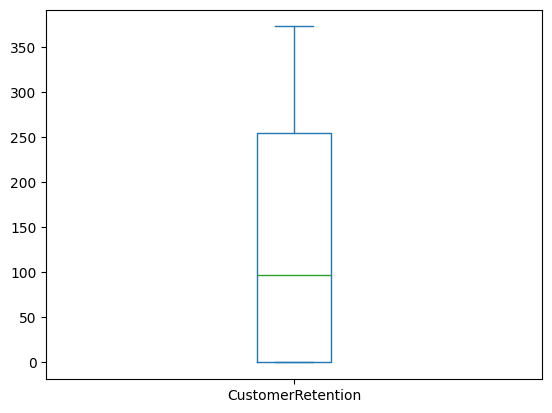

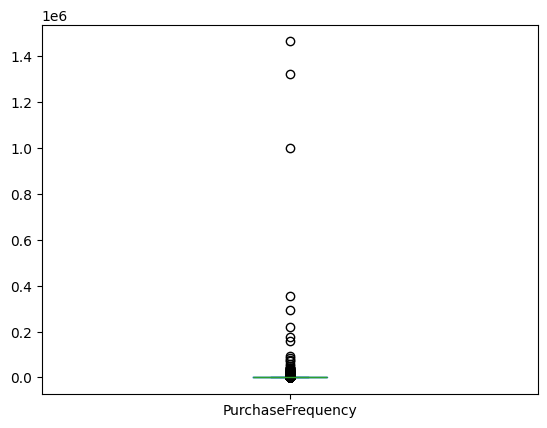

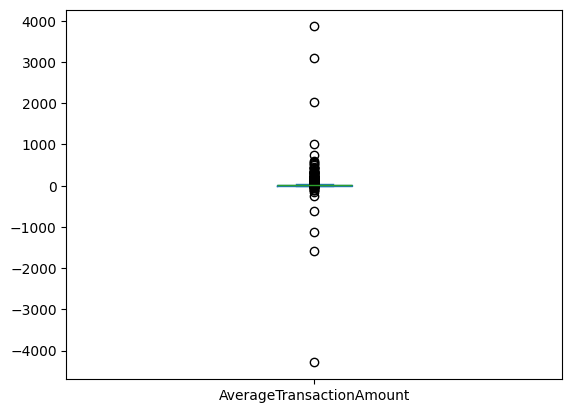

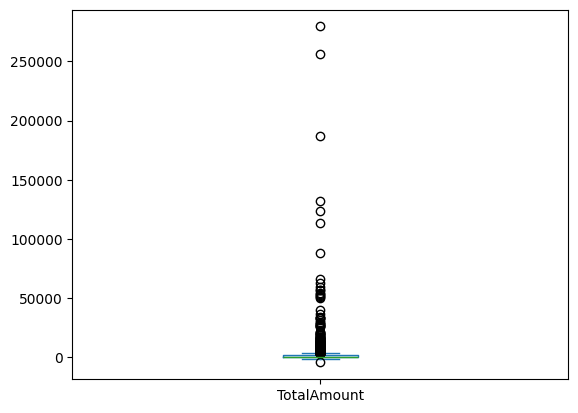

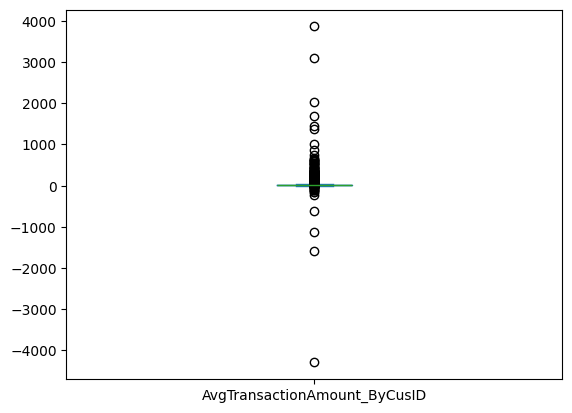

In [ ]:
#Detect outliers and Visuaise with boxplot for numerical values
customer_df['CustomerRetention'].plot(kind='box')
plt.show()
customer_df['PurchaseFrequency'].plot(kind='box')
plt.show()
customer_df['AverageTransactionAmount'].plot(kind='box')
plt.show()
customer_df['TotalAmount'].plot(kind='box')
plt.show()
customer_df['AvgTransactionAmount_ByCusID'].plot(kind='box')
plt.show()

Lower bound for outliers: -696.0
Upper bound for outliers: 1224.0
Outlier Scores (Before Replacement):
1        1274
12       1506
15       3562
39       2385
55      20228
        ...  
4330     3280
4340     1890
4342     1416
4351     1476
4370    11536
Name: PurchaseFrequency, Length: 614, dtype: int64


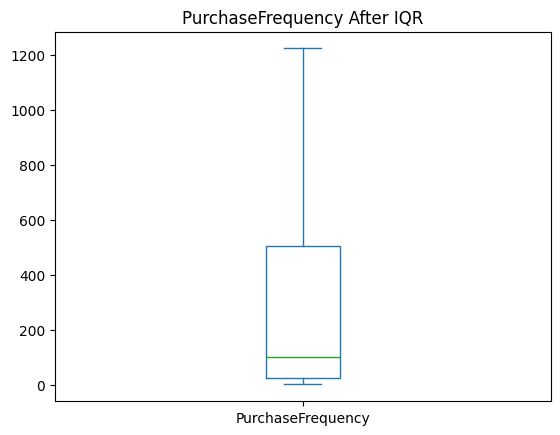

Lower bound for outliers: -14.635849083835343
Upper bound for outliers: 31.135909450301206
Outlier Scores (Before Replacement):
8        35.338462
10       47.386794
45       34.141667
46       31.673889
73      108.748472
           ...    
4321     37.222500
4334    440.000000
4339     70.430000
4343     74.512500
4347    269.670000
Name: AverageTransactionAmount, Length: 318, dtype: float64


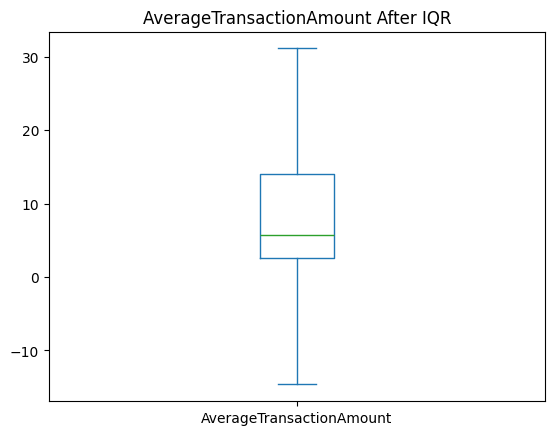

In [ ]:
# Function to remove outliers using IQR
#PurchaseFrequency
Q1 = customer_df['PurchaseFrequency'].quantile(0.25)
Q3 = customer_df['PurchaseFrequency'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
#Print out Outliers in the boxplot
outliers = customer_df[(customer_df['PurchaseFrequency'] < lower_bound) | (customer_df['PurchaseFrequency'] > upper_bound)]
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)
print("Outlier Scores (Before Replacement):")
print(outliers['PurchaseFrequency'])
#Apply IQR
customer_df['PurchaseFrequency'] = customer_df['PurchaseFrequency'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
customer_df['PurchaseFrequency'].plot(kind='box')
plt.title("PurchaseFrequency After IQR")
plt.show()



#AverageTrasactionAmount
Q1 = customer_df['AverageTransactionAmount'].quantile(0.25)
Q3 = customer_df['AverageTransactionAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
#Print out Outliers
outliers = customer_df[(customer_df['AverageTransactionAmount'] < lower_bound) | (customer_df['AverageTransactionAmount'] > upper_bound)]
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)
print("Outlier Scores (Before Replacement):")
print(outliers['AverageTransactionAmount'])
#Apply IQR
customer_df['AverageTransactionAmount'] = customer_df['AverageTransactionAmount'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
customer_df['AverageTransactionAmount'].plot(kind='box')
plt.title("AverageTransactionAmount After IQR")
plt.show()

Lower bound for outliers: -1683.0149999999999
Upper bound for outliers: 3583.145
Outlier Scores (Before Replacement):
1       4310.00
10      6207.67
12      6182.98
15      5154.58
27      4008.62
         ...   
4324    6315.23
4326    5356.86
4327    5192.10
4330    7276.90
4347    4314.72
Name: TotalAmount, Length: 421, dtype: float64


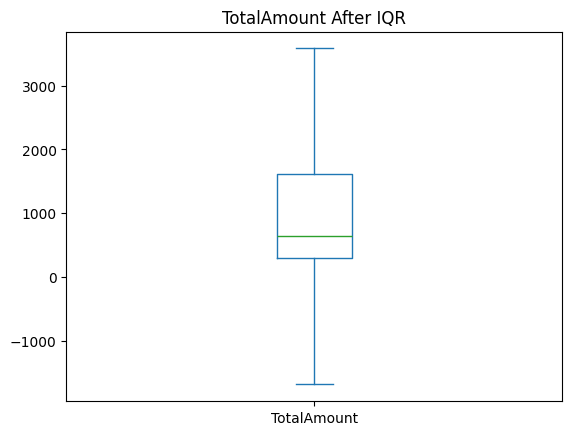

Lower bound for outliers: -7.705598347547966
Upper bound for outliers: 42.35364472281449
Outlier Scores
2        57.975484
9        47.651356
10       47.386794
11       61.476842
38       47.128889
           ...    
4343    149.025000
4347    269.670000
4350    -12.525000
4352     55.680952
4362     68.000000
Name: AvgTransactionAmount_ByCusID, Length: 505, dtype: float64


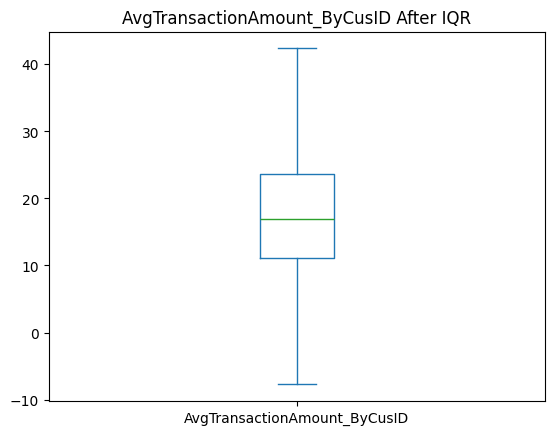

In [ ]:
#Applying IQR to remove outliers
#TotalAmount
Q1 = customer_df['TotalAmount'].quantile(0.25)
Q3 = customer_df['TotalAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
#Print Outliers
outliers = customer_df[(customer_df['TotalAmount'] < lower_bound) | (customer_df['TotalAmount'] > upper_bound)]
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)
print("Outlier Scores (Before Replacement):")
print(outliers['TotalAmount'])
#Apply IQR
customer_df['TotalAmount'] = customer_df['TotalAmount'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
customer_df['TotalAmount'].plot(kind='box')
plt.title("TotalAmount After IQR")
plt.show()



#AvgTrasactionAmount_ByCusID
Q1 = customer_df['AvgTransactionAmount_ByCusID'].quantile(0.25)
Q3 = customer_df['AvgTransactionAmount_ByCusID'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
#Print Outliers
outliers = customer_df[(customer_df['AvgTransactionAmount_ByCusID'] < lower_bound) | (customer_df['AvgTransactionAmount_ByCusID'] > upper_bound)]
print("Lower bound for outliers:", lower_bound)
print("Upper bound for outliers:", upper_bound)
print("Outlier Scores")
print(outliers['AvgTransactionAmount_ByCusID'])
#Apply IQR
customer_df['AvgTransactionAmount_ByCusID'] = customer_df['AvgTransactionAmount_ByCusID'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
customer_df['AvgTransactionAmount_ByCusID'].plot(kind='box')
plt.title("AvgTransactionAmount_ByCusID After IQR")
plt.show()

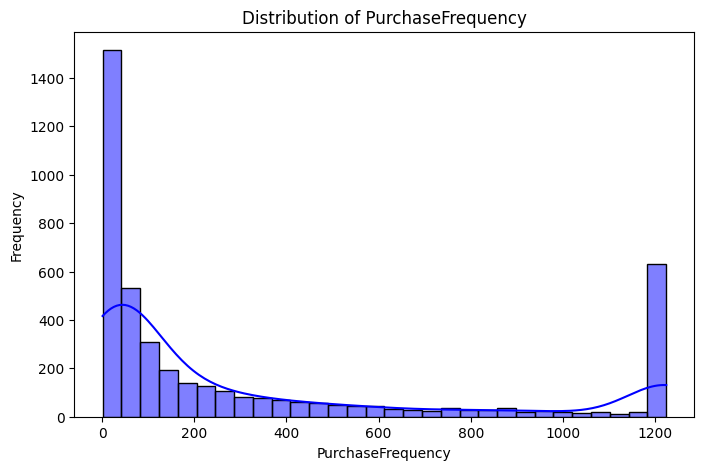

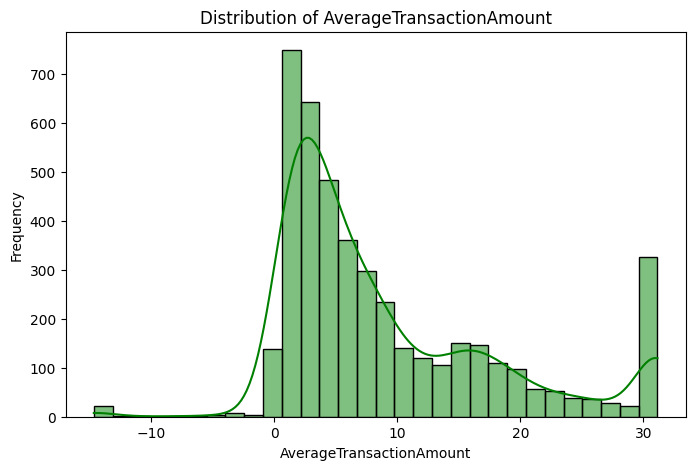

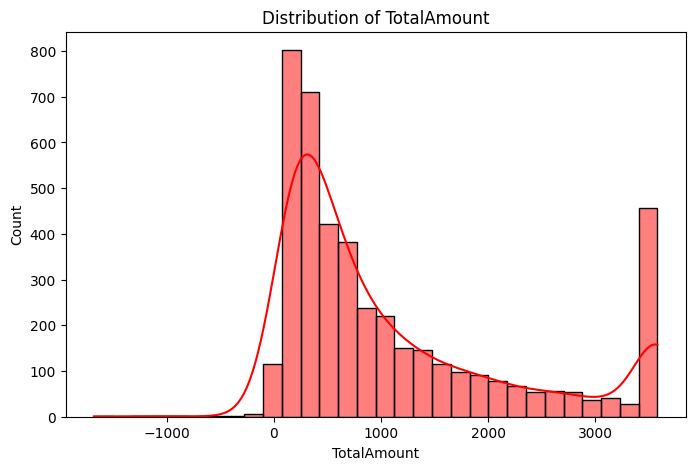

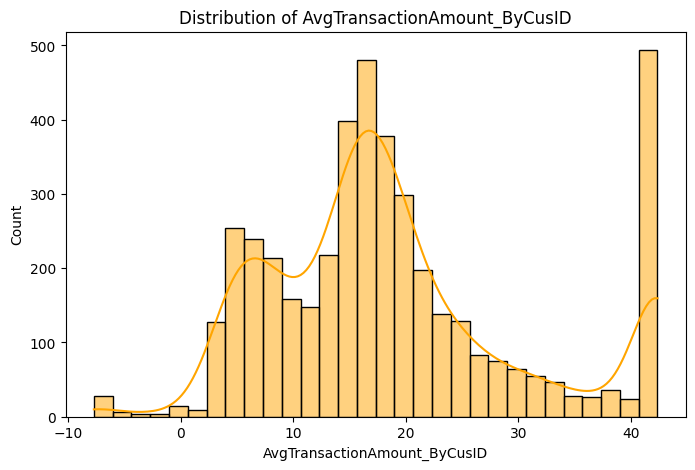

In [ ]:
#Plot distribution for Customer Retention
# Plot distribution for PurchaseFrequency

plt.figure(figsize=(8, 5))
sns.histplot(customer_df['PurchaseFrequency'], kde=True, bins=30, color='blue')
plt.title('Distribution of PurchaseFrequency')
plt.xlabel('PurchaseFrequency')
plt.ylabel('Frequency')
plt.show()

# Plot distribution for AverageTransactionAmount
plt.figure(figsize=(8, 5))
sns.histplot(customer_df['AverageTransactionAmount'], kde=True, bins=30, color='green')
plt.title('Distribution of AverageTransactionAmount')
plt.xlabel('AverageTransactionAmount')
plt.ylabel('Frequency')
plt.show()

#Plot distribution for TotalAmount
plt.figure(figsize=(8, 5))
sns.histplot(customer_df['TotalAmount'], kde=True, bins=30, color='red')
plt.title('Distribution of TotalAmount')
plt.xlabel('TotalAmount')

#Plot distribution for AvgTransactionAmount_ByCusID
plt.figure(figsize=(8, 5))
sns.histplot(customer_df['AvgTransactionAmount_ByCusID'], kde=True, bins=30, color='orange')
plt.title('Distribution of AvgTransactionAmount_ByCusID')
plt.xlabel('AvgTransactionAmount_ByCusID')
plt.show()

CustomerID                      float64
PurchaseFrequency               float64
TotalAmount                     float64
AverageTransactionAmount        float64
CustomerRetention                 int64
Quantity                          int64
AvgTransactionAmount_ByCusID    float64
CLV                             float64
dtype: object


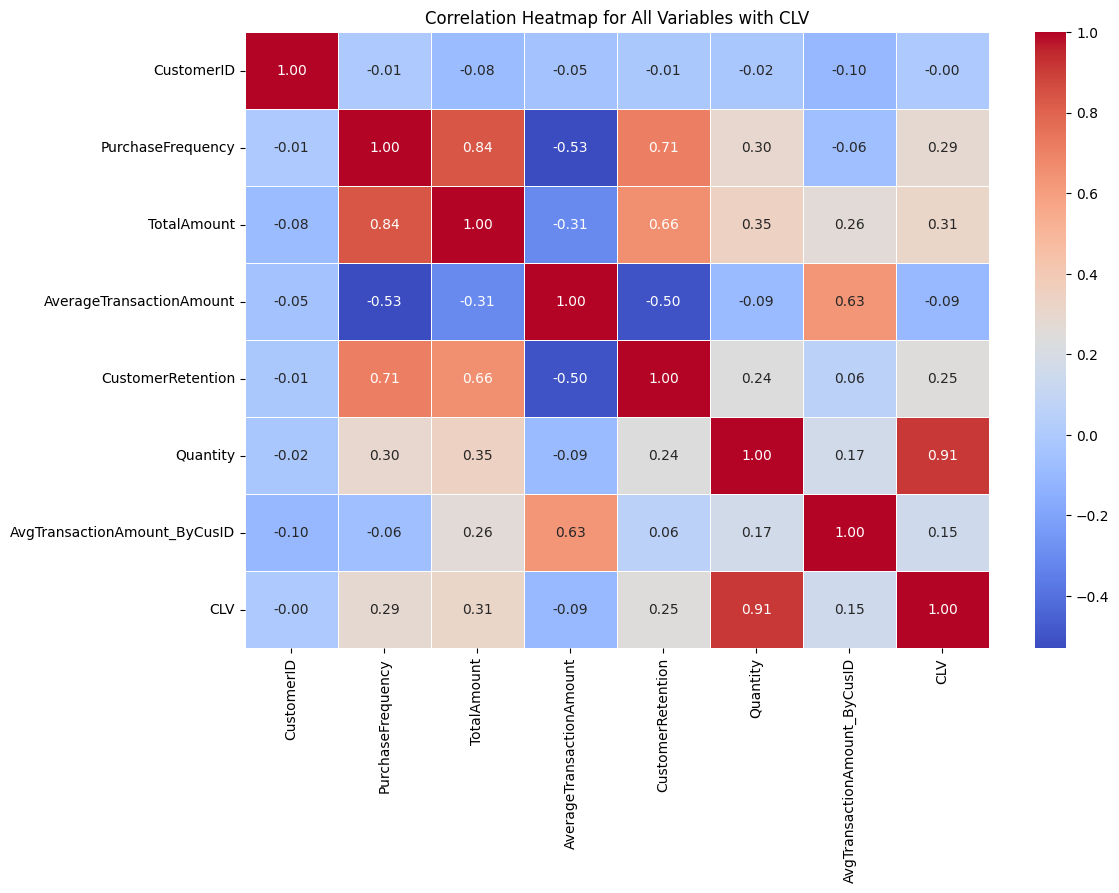

In [ ]:
# Correlation Matrix
print(customer_df.dtypes)
numeric_columns = customer_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = customer_df[numeric_columns].corr()

#visualise with heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for All Variables with CLV')
plt.show()

In [ ]:

# Defining features and target variable
features = ['CustomerRetention','AvgTransactionAmount_ByCusID', 'PurchaseFrequency','AverageTransactionAmount']
X = customer_df[features]
y = customer_df['CLV']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"Performance of {model_name}:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_true, y_pred):.2f}")
    print(f"R-squared (R²): {r2_score(y_true, y_pred):.2f}")
    print("-" * 40)

evaluate_model(y_test, y_pred_linear, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# Feature importance (coefficients) from models
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Linear": linear_model.coef_,
    "Ridge": ridge_model.coef_,
    "Lasso": lasso_model.coef_
})
print(coefficients.sort_values(by='Linear', key=abs, ascending=False).head(10))

Performance of Linear Regression:
Mean Absolute Error (MAE): 715029.13
Mean Squared Error (MSE): 7733100259227.41
R-squared (R²): 0.14
----------------------------------------
Performance of Ridge Regression:
Mean Absolute Error (MAE): 714853.74
Mean Squared Error (MSE): 7733205872780.16
R-squared (R²): 0.14
----------------------------------------
Performance of Lasso Regression:
Mean Absolute Error (MAE): 715029.02
Mean Squared Error (MSE): 7733100316644.73
R-squared (R²): 0.14
----------------------------------------
                        Feature         Linear          Ridge          Lasso
1  AvgTransactionAmount_ByCusID  699020.759805  698357.239617  699020.421048
2             PurchaseFrequency  655348.597368  655063.370803  655348.597516
3      AverageTransactionAmount -349841.165395 -349186.642607 -349840.798612
0             CustomerRetention   14969.193638   15541.169409   14969.300658


In [ ]:
# Visualisation of